In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np
import pickle
import os
from PIL import Image

from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import h5py

from time import time

from classes import *

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# From Assignment 2 PyTorch Notebook
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [3]:
data_directory = '.'

##########################################################################################
#                                  BATCH_SIZE PARAMETER
BATCH_SIZE = 1000
##########################################################################################


# sr_train = SR_Dataset(data_directory, train=TRAIN_MODE)
# loader_train = DataLoader(sr_train, batch_size=BATCH_SIZE, 
#                           sampler=sampler.SubsetRandomSampler(range(TRAIN_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
#                          num_workers = 4)


sr_val = SR_Dataset(data_directory, train=VAL_MODE)
loader_val = DataLoader(sr_val, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(VAL_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

In [4]:
# input shape: (days, height, width). calculates rmse of each pixel.
# or input shape: (N, C, H, W), same thing.
def rmse_pixel(gen, target):
    return np.sqrt(np.mean(np.square(gen - target), axis = 0))


In [5]:
# y, y_pred: (N, C, H, W)
def get_extremes(y, y_pred, quantiles, metric_fn):
    output = np.zeros((2, len(quantiles), 2)) # channel, quantile, [mean/variance]
    for q_index, q in enumerate(quantiles):
        y_precip = y[:, 0, :, :]
        y_pred_precip = y_pred[:, 0, :, :]
        y_temp = y[:, 1, :, :]
        y_pred_temp = y_pred[:, 1, :, :]
        
        H = y.shape[2]
        W = y.shape[3]
        # [precip|temp]_indices are (num_values*H*W, 3) arrays, where num_values is the number of values
        # above this percentile, and the 3 columns correspodn to the three coordinates (see the for loops)
        # below
        precip_indices = np.array(np.where(y_precip > np.percentile(a = y_precip, q = q, axis = 0))).T
        temp_indices = np.array(np.where(y_temp > np.percentile(a = y_temp, q = q, axis = 0))).T
        num_values = int(precip_indices.shape[0] / (H * W)) + 1
        y_precip_extreme = np.zeros((num_values, H, W))
        y_pred_precip_extreme = np.zeros((num_values, H, W))
        y_temp_extreme = np.zeros((num_values, H, W))
        y_pred_temp_extreme = np.zeros((num_values, H, W))
#         if num_values <= 2: continue
        # coordinates aren't in order of pixel, so keep track of how many values we've layered
        # for each pixel so far
        counters = np.zeros((H, W), dtype = int)
        for i, j, k in precip_indices:
            y_precip_extreme[counters[j, k], j, k] = y_precip[i, j, k]
            y_pred_precip_extreme[counters[j, k], j, k] = y_pred_precip[i, j, k]
            counters[j, k] += 1
        counters = np.zeros((H, W), dtype = int)
        for i, j, k in temp_indices:
            y_temp_extreme[counters[j, k], j, k] = y_temp[i, j, k]
            y_pred_temp_extreme[counters[j, k], j, k] = y_pred_temp[i, j, k]
            counters[j, k] += 1

        metric_precip = metric_fn(y_precip_extreme, y_pred_precip_extreme)
        metric_temp = metric_fn(y_temp_extreme, y_pred_temp_extreme)
        output[0, q_index, 0] = np.mean(metric_precip)
        output[0, q_index, 1] = np.var(metric_precip)
        output[1, q_index, 0] = np.mean(metric_temp)
        output[1, q_index, 1] = np.var(metric_temp)
    return output

In [6]:
# G is generic for any image-generating model; could be SRCNN too
def get_metrics(loader, G):
    G = G.to(device=device)
    G.eval() # set model to evaluation mode
    
    # initialize metrics
    final_rmse = None
    extreme_quantiles = [i / 10 for i in range(900, 1000, 5)]
    extreme_metrics = [] # list will be populated with metrics from each batch
    count = 0
    
    # calculate all metrics in one pass through val set
    with torch.no_grad():
        count = 0
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            y_pred = G(x)
            y = y.cpu().numpy()
            y_pred = y_pred.cpu().numpy()
            if final_rmse is not None:
                final_rmse += rmse_pixel(y, y_pred)
            else:
                final_rmse = rmse_pixel(y, y_pred)
            extreme_metrics.append(get_extremes(y, y_pred, extreme_quantiles, rmse_pixel))
            count += 1
            print('Done with batch %d.' % count)
        final_rmse /= count
        # num_batches, channel, quantile, [mean|variance]
        extreme_metrics = np.array(extreme_metrics)
        # channel, quantile, [mean|variance]
        extreme_metrics = np.mean(extreme_metrics, axis = 0)
    return final_rmse, extreme_metrics

In [7]:
G = Generator(num_channels=3)

# Load the states from training on full dataset
G.load_state_dict(torch.load('SRGAN_G_06_05_best_precip.pt'))

final_rmse, extreme_metrics = get_metrics(loader_val, G)

Done with batch 1.
Done with batch 2.
Done with batch 3.
Done with batch 4.
Done with batch 5.
Done with batch 6.
Done with batch 7.
Done with batch 8.


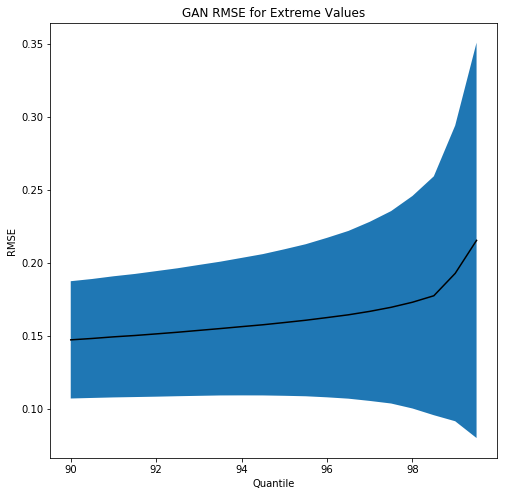

In [9]:
extreme_quantiles = [i / 10 for i in range(900, 1000, 5)]
# quantile, [mean|variance]
extreme_metrics_precip = extreme_metrics[0, :, :]
plt.figure(figsize = (8, 8))
plt.fill_between(
    extreme_quantiles, 
    extreme_metrics_precip[:, 0] - np.sqrt(extreme_metrics_precip[:, 1]),
    extreme_metrics_precip[:, 0] + np.sqrt(extreme_metrics_precip[:, 1]),
)
plt.plot(extreme_quantiles, extreme_metrics_precip[:, 0], 'k')
plt.xlabel('Quantile')
plt.ylabel('RMSE')
plt.title('GAN RMSE for Extreme Values')
plt.show()

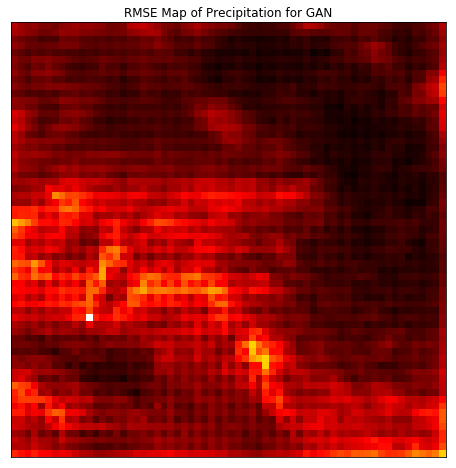

In [10]:
plt.figure(figsize = (8, 8))
plt.imshow(final_rmse[0, :, :], cmap = 'hot')
plt.title('RMSE Map of Precipitation for GAN')
plt.tick_params(
    axis= 'both',
    left = False,
    bottom = False,
    labelleft = False,
    labelbottom = False
)
plt.show()

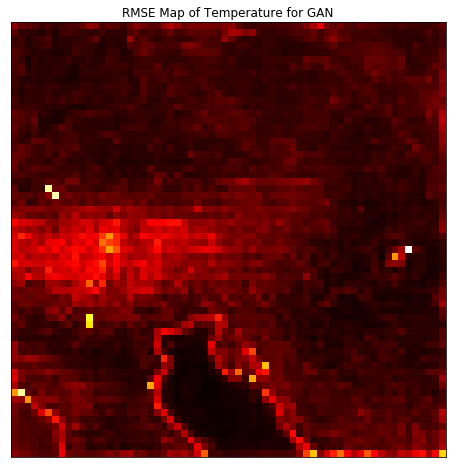

In [12]:
plt.figure(figsize = (8, 8))
plt.imshow(final_rmse[1, :, :], cmap = 'hot')
plt.title('RMSE Map of Temperature for GAN')
plt.tick_params(
    axis= 'both',
    left = False,
    bottom = False,
    labelleft = False,
    labelbottom = False
)
plt.show()

In [13]:
import csv

with open('extreme_analysis_SRGAN.csv', 'w') as extreme_csv:
    writer = csv.writer(extreme_csv)
    writer.writerow(['Quantile', 'PrecipMean', 'PrecipVar', 'TempMean', 'TempVar'])
    for i in range(len(extreme_quantiles)):
        writer.writerow([extreme_quantiles[i]] + list(extreme_metrics[0,i,:]) + list(extreme_metrics[1,i,:]))